#### Libraries


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from mistune.plugins.abbr import parse_ref_abbr
from mlxtend.evaluate.bootstrap_point632 import accuracy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
data = pd.read_csv('../2 - Data/develop.csv')
target = 'Ins'

In [2]:
# Preprocess data
def preprocess_data(df, target_column):
    df = df.copy()
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Feature Engineering
    X['ATM Withdrawal Ratio'] = X['ATMAmt'] / (X['DDABal'] + 1)
    X['Credit Card Usage Ratio'] = X['CCPurc'] / (X['CCBal'] + 1)
    X['Income to Loan Ratio'] = X['Income'] / (X['ILSBal'] + X['MTGBal'] + 1)
    X['Total Account Balance'] = X['DDABal'] + X['SavBal'] + X['MMBal'] + X['IRABal'] + X['InvBal'] + X['CDBal']
    X['Credit Usage Balance'] = X['CCBal'] + X['LOCBal']
    X['Total Deposits'] = X['DepAmt'] + X['POSAmt']
    X['Transaction Count'] = X['CashBk'] + X['Checks'] + X['Teller'] + X['POS']
    X['Financial Diversity'] = X[['CC', 'CD', 'DDA', 'IRA', 'LOC', 'MM', 'MTG', 'SDB', 'Sav', 'Inv']].sum(axis=1)
    X['Loan to Home Value Ratio'] = (X['ILSBal'] + X['MTGBal']) / (X['HMVal'] + 1)
    X['Checking Balance Stability'] = X['DDABal'] / (X['Income'] + 1)
    
    # Drop original interval variables used in new features
    X.drop(['ATMAmt', 'CCPurc', 'CCBal', 'ILSBal', 'MTGBal', 'Income', 'DDABal', 
            'SavBal', 'MMBal', 'IRABal', 'InvBal', 'CDBal', 'POSAmt', 'DepAmt'], axis=1, inplace=True)
    
    # Convert categorical variables to dummies
    X = pd.get_dummies(X, drop_first=True)
    
    # Impute missing values (if any)
    X.fillna(X.median(), inplace=True)
    
    return X, y

In [3]:
X, y = preprocess_data(data, target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)


In [4]:
#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Apply PCA to reduce dimensions for visualization
#pca = PCA(n_components=3)
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

In [5]:
svm_model_rbf = SVC(kernel='rbf', probability=True, random_state=42).fit(X_train_scaled, y_train)
svm_model_poly = SVC(kernel='poly', degree=3, probability=True, random_state=42).fit(X_train_scaled, y_train)
svm_model_sigmoid = SVC(kernel='sigmoid', probability=True, random_state=42).fit(X_train_scaled, y_train)

Evaluating Poly SVM...
Poly SVM Accuracy: 0.705
Poly SVM AUC Score: 0.726

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      4218
           1       0.64      0.33      0.44      2235

    accuracy                           0.71      6453
   macro avg       0.68      0.62      0.62      6453
weighted avg       0.69      0.71      0.67      6453

Poly SVM Confusion Matrix:
[[3811  407]
 [1496  739]]


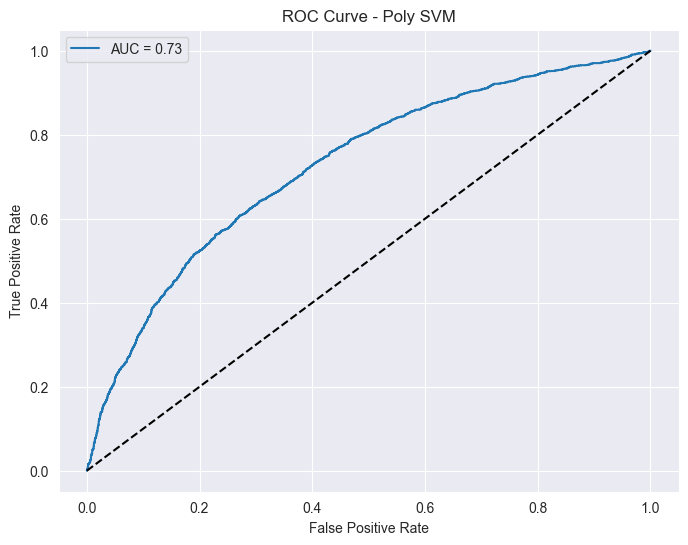

Evaluating RBF SVM...
RBF SVM Accuracy: 0.715
RBF SVM AUC Score: 0.758

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4218
           1       0.64      0.40      0.49      2235

    accuracy                           0.71      6453
   macro avg       0.69      0.64      0.65      6453
weighted avg       0.70      0.71      0.69      6453

RBF SVM Confusion Matrix:
[[3719  499]
 [1342  893]]


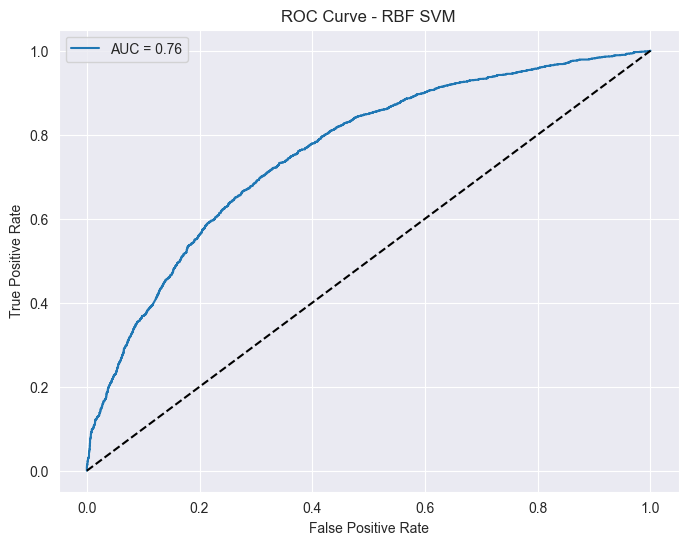

Evaluating Sigmoid SVM...
Sigmoid SVM Accuracy: 0.629
Sigmoid SVM AUC Score: 0.611

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      4218
           1       0.46      0.45      0.45      2235

    accuracy                           0.63      6453
   macro avg       0.59      0.59      0.59      6453
weighted avg       0.63      0.63      0.63      6453

Sigmoid SVM Confusion Matrix:
[[3061 1157]
 [1240  995]]


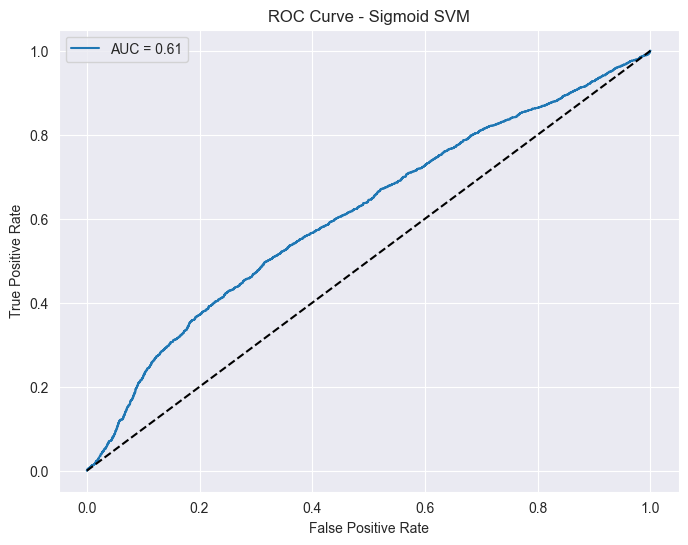

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# List of models to evaluate
models = {
    'Poly SVM': svm_model_poly,
    'RBF SVM': svm_model_rbf,
    'Sigmoid SVM': svm_model_sigmoid
}

# Iterate through each model and evaluate
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Print evaluation results
    print(f"{model_name} Accuracy: {accuracy:.3f}")
    print(f"{model_name} AUC Score: {auc_score:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the model
svm_model_rbf = SVC(kernel='rbf', probability=True)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1]  # Kernel coefficient
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=svm_model_rbf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best AUC Score: {best_score:.3f}")

# Train the model with best parameters
svm_model_rbf_tuned = SVC(kernel='rbf', probability=True, C=best_params['C'], gamma=best_params['gamma'])
svm_model_rbf_tuned.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .................................C=0.1, gamma=0.001; total time= 5.3min
[CV] END .....................................C=0.1, gamma=1; total time=12.6min
[CV] END .....................................C=1, gamma=0.1; total time=13.1min
[CV] END ..................................C=10, gamma=0.001; total time= 5.1min
[CV] END ......................................C=10, gamma=1; total time=40.2min
[CV] END .................................C=100, gamma=0.01; total time=105.6min
[CV] END ..................................C=0.1, gamma=0.01; total time= 5.2min
[CV] END ...................................C=0.1, gamma=0.1; total time=10.5min
[CV] END ....................................C=1, gamma=0.01; total time= 5.0min
[CV] END .......................................C=1, gamma=1; total time=14.9min
[CV] END ....................................C=10, gamma=0.1; total time=22.2min
[CV] END .................................C=100,

SVC(C=10, gamma=0.001, probability=True)